In [225]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [226]:
DATA_FOLDER = 'data/'
RAW_DATA_FILE = os.path.join(DATA_FOLDER, 'raw_with_weather.feather')
GEO_DATA_FILE = 'US_Zip_City/uszips.csv'
TRAIN_DATA_FILE = os.path.join(DATA_FOLDER, 'train.feather')
TEST_DATA_FILE = os.path.join(DATA_FOLDER, 'test.feather')

TARGET = 'TOTALKWH'

# Load data

In [227]:
raw = pd.read_feather(RAW_DATA_FILE)

In [228]:
# load geo data
geo = pd.read_csv(GEO_DATA_FILE)

In [229]:
geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33783 entries, 0 to 33782
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   zip               33783 non-null  int64  
 1   lat               33783 non-null  float64
 2   lng               33783 non-null  float64
 3   city              33783 non-null  object 
 4   state_id          33783 non-null  object 
 5   state_name        33783 non-null  object 
 6   zcta              33783 non-null  bool   
 7   parent_zcta       0 non-null      float64
 8   population        33764 non-null  float64
 9   density           33764 non-null  float64
 10  county_fips       33783 non-null  int64  
 11  county_name       33783 non-null  object 
 12  county_weights    33783 non-null  object 
 13  county_names_all  33783 non-null  object 
 14  county_fips_all   33783 non-null  object 
 15  imprecise         33783 non-null  bool   
 16  military          33783 non-null  bool  

For convenience, you can skip 1-5 and jump to [Write 1-5 together](#Write-1-5-together).

# 1. Merge geo data into raw data

In [230]:
data = raw.copy()

In [231]:
# remove commas from TOTALKWH
data[TARGET] = data[TARGET].str.replace(',', '')  
# to float
data[TARGET] = data[TARGET].astype(float)
# Drop rows with TOTALKWH = 0
data = data[data[TARGET] != 0]
# Calculate date based on YEAR and MONTH
data['YEAR_MONTH'] = pd.to_datetime(data['YEAR'].astype(str) + '-' + data['MONTH'].astype(str) + '-01')

In [232]:
# merge geo data into raw data
data_add_geo = data.merge(geo, left_on='ZIPCODE', right_on='zip', how='left')

In [233]:
data_add_geo.columns

Index(['ZIPCODE', 'MONTH', 'YEAR', 'CUSTOMERCLASS', 'COMBINED',
       'TOTALCUSTOMERS', 'TOTALKWH', 'AVERAGEKWH', 'dewptAvg', 'heatindexAvg',
       'humidityAvg', 'precipRate', 'tempAvg', 'windchillAvg', 'winddirAvg',
       'windgustAvg', 'windspeedAvg', 'YEAR_MONTH', 'zip', 'lat', 'lng',
       'city', 'state_id', 'state_name', 'zcta', 'parent_zcta', 'population',
       'density', 'county_fips', 'county_name', 'county_weights',
       'county_names_all', 'county_fips_all', 'imprecise', 'military',
       'timezone'],
      dtype='object')

In [234]:
data_add_geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66100 entries, 0 to 66099
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ZIPCODE           66100 non-null  int64         
 1   MONTH             66100 non-null  int64         
 2   YEAR              66100 non-null  object        
 3   CUSTOMERCLASS     66100 non-null  object        
 4   COMBINED          66100 non-null  object        
 5   TOTALCUSTOMERS    66100 non-null  object        
 6   TOTALKWH          66100 non-null  float64       
 7   AVERAGEKWH        66100 non-null  object        
 8   dewptAvg          64443 non-null  float64       
 9   heatindexAvg      65445 non-null  float64       
 10  humidityAvg       65465 non-null  float64       
 11  precipRate        63676 non-null  float64       
 12  tempAvg           65532 non-null  float64       
 13  windchillAvg      64527 non-null  float64       
 14  winddirAvg        6480

In [235]:
data_add_geo.head()

,ZIPCODE,MONTH,YEAR,CUSTOMERCLASS,COMBINED,TOTALCUSTOMERS,TOTALKWH,AVERAGEKWH,dewptAvg,heatindexAvg,...,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone
0,93206,2,2020,Elec- Agricultural,Y,259,14046480.0,"54,234",39.044828,53.110345,...,1953.0,4.6,6029.0,Kern,"{""06029"": 100}",Kern,06029,False,False,America/Los_Angeles
1,93206,3,2020,Elec- Agricultural,Y,349,21871997.0,"62,670",44.723333,56.810000,...,1953.0,4.6,6029.0,Kern,"{""06029"": 100}",Kern,06029,False,False,America/Los_Angeles
2,93210,2,2020,Elec- Agricultural,N,108,2732693.0,"25,303",28.275000,52.982143,...,18975.0,9.4,6019.0,Fresno,"{""06019"": 90.26, ""06053"": 6.38, ""06069"": 3.36}",Fresno|Monterey|San Benito,06019|06053|06069,False,False,America/Los_Angeles
3,93210,3,2020,Elec- Agricultural,N,109,2892721.0,"26,539",35.059091,54.009091,...,18975.0,9.4,6019.0,Fresno,"{""06019"": 90.26, ""06053"": 6.38, ""06069"": 3.36}",Fresno|Monterey|San Benito,06019|06053|06069,False,False,America/Los_Angeles
4,93234,2,2020,Elec- Agricultural,N,115,1765301.0,"15,350",38.353571,52.992857,...,6477.0,18.5,6019.0,Fresno,"{""06019"": 100}",Fresno,06019,False,False,America/Los_Angeles


# 2. Basic data cleaning

In [236]:
DROP_COLS = []

In [237]:
# Select only numeric columns
num_data = data_add_geo.select_dtypes(include=['float64'])

In [238]:
# Drop unnecessary columns
DROP_COLS.extend(['zip', 'lat', 'lng', 'parent_zcta', 'county_fips'])
num_data.drop(columns=[col for col in DROP_COLS if col in num_data.columns], inplace=True)

In [239]:
# Drop rows with no values
num_data.dropna(inplace=True)

In [240]:
num_data.columns

Index(['TOTALKWH', 'dewptAvg', 'heatindexAvg', 'humidityAvg', 'precipRate',
       'tempAvg', 'windchillAvg', 'winddirAvg', 'windgustAvg', 'windspeedAvg',
       'population', 'density'],
      dtype='object')

In [241]:
num_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61805 entries, 0 to 66096
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TOTALKWH      61805 non-null  float64
 1   dewptAvg      61805 non-null  float64
 2   heatindexAvg  61805 non-null  float64
 3   humidityAvg   61805 non-null  float64
 4   precipRate    61805 non-null  float64
 5   tempAvg       61805 non-null  float64
 6   windchillAvg  61805 non-null  float64
 7   winddirAvg    61805 non-null  float64
 8   windgustAvg   61805 non-null  float64
 9   windspeedAvg  61805 non-null  float64
 10  population    61805 non-null  float64
 11  density       61805 non-null  float64
dtypes: float64(12)
memory usage: 6.1 MB


In [242]:
num_data.head()

,TOTALKWH,dewptAvg,heatindexAvg,humidityAvg,precipRate,tempAvg,windchillAvg,winddirAvg,windgustAvg,windspeedAvg,population,density
0,14046480.0,39.044828,53.110345,62.758621,0.000000,53.286207,53.279310,166.379310,1.255172,0.868966,1953.0,4.6
1,21871997.0,44.723333,56.810000,67.160000,0.034667,56.876667,56.860000,238.700000,2.486667,1.776667,1953.0,4.6
2,2732693.0,28.275000,52.982143,41.692857,0.000000,53.192857,51.775000,297.857143,8.892857,5.821429,18975.0,9.4
3,2892721.0,35.059091,54.009091,53.595455,0.012273,54.163636,53.277273,273.136364,9.863636,6.290909,18975.0,9.4
4,1765301.0,38.353571,52.992857,61.042857,0.000000,53.021429,52.742857,268.750000,7.182143,4.085714,6477.0,18.5


In [243]:
X = num_data.drop(columns=[TARGET])
y = num_data[TARGET]

# 3. Filter columns by correlation with target

In [244]:
def cal_corr(X, y, method, plot=True):
    """
    Calculate correlation of features with target and plot the result.
    
    Input:
    - X: DataFrame, features
    - y: Series, target
    - method: str, correlation method, 'pearson' or 'spearman'
    - plot: bool, whether to plot the result
    
    Output:
    - cor: Series, correlation of features with target
    
    Sample usage:
    cal_corr(X, y, method='pearson')
    """
    cor = X.apply(lambda col: col.corr(y, method=method)).sort_values(ascending=False)
    if plot:
        plt.figure(figsize=(10, 5))
        sns.barplot(x=cor.index, y=cor.values)
        plt.xticks(rotation=90)
        plt.title('Correlation of Features with Target')
        plt.xlabel('Features')
        plt.ylabel('Correlation')
        plt.show()
    return cor

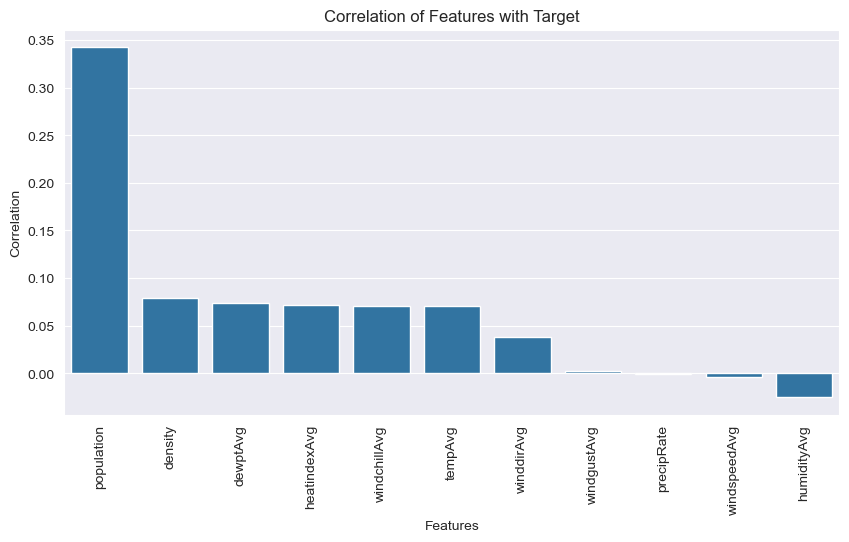

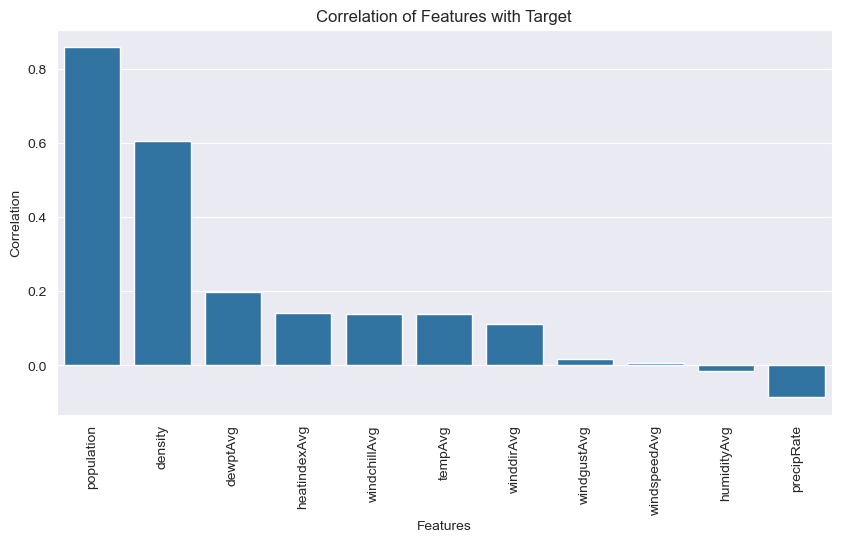

In [245]:
cor_pearson = cal_corr(X, y, method='pearson')
cor_spearman = cal_corr(X, y, method='spearman')

In [246]:
# drop cols with low correlation (absolute value < 0.1, both methods) with target
threshold = 0.1
for col in X.columns:
    if abs(cor_pearson[col]) < threshold and abs(cor_spearman[col]) < threshold:
        DROP_COLS.append(col)
X_dropped1 = X.drop(columns=[col for col in DROP_COLS if col in X.columns])

In [247]:
X_dropped1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61805 entries, 0 to 66096
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   dewptAvg      61805 non-null  float64
 1   heatindexAvg  61805 non-null  float64
 2   tempAvg       61805 non-null  float64
 3   windchillAvg  61805 non-null  float64
 4   winddirAvg    61805 non-null  float64
 5   population    61805 non-null  float64
 6   density       61805 non-null  float64
dtypes: float64(7)
memory usage: 3.8 MB


# 4. Filter columns by multi-collinearity

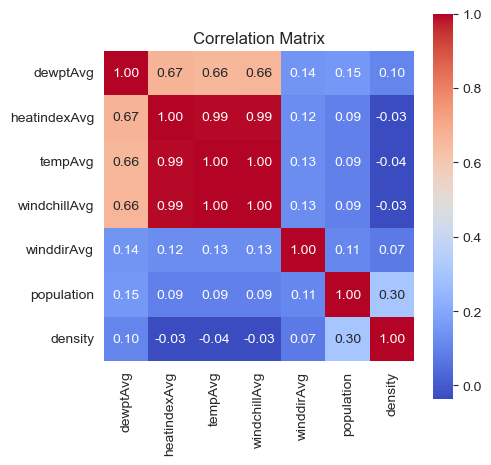

In [248]:
# correlation matrix
corr = pd.DataFrame(X_dropped1, columns=X_dropped1.columns).corr()
plt.figure(figsize=(5, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix')
plt.show()

In [249]:
# dewptAvg is of medium correlation (0.66) with tempAvg and heatindexAvg, so we will calculate VIF to check.
# manually drop cols with high correlation with each other (absolute value > 0.9)
DROP_COLS.extend(['heatindexAvg', 'windchillAvg'])
X_dropped2 = X_dropped1.drop(columns=[drop_col for drop_col in DROP_COLS if drop_col in X_dropped1.columns])

In [250]:
X_dropped2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61805 entries, 0 to 66096
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dewptAvg    61805 non-null  float64
 1   tempAvg     61805 non-null  float64
 2   winddirAvg  61805 non-null  float64
 3   population  61805 non-null  float64
 4   density     61805 non-null  float64
dtypes: float64(5)
memory usage: 2.8 MB


In [251]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X):
    """
    Calculate Variance Inflation Factor (VIF) for each feature in the dataset.
    
    Input:
    - X: DataFrame, features
    
    Output:
    - vif: DataFrame, VIF for each feature, sorted by VIF value
    """
    vif = pd.DataFrame()
    vif['feature'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif
calculate_vif(X_dropped2)

# Very high VIF (> 40) of dewptAvg and tempAvg. So drop dewptAvg from domain knowledge.

,feature,VIF
0,dewptAvg,45.812197
1,tempAvg,44.246657
2,winddirAvg,9.447030
3,population,2.271268
4,density,1.367975


In [252]:
X_dropped2.drop(columns=['dewptAvg'], inplace=True)

In [253]:
# merge y back to X
data_dropped = pd.concat([X_dropped2, y], axis=1)
data_dropped['YEAR_MONTH'] = data_add_geo['YEAR_MONTH']

# 5. Solve missing values

In [254]:
# print missing percentage
missing_percentage = data_dropped.isnull().sum() / len(data_dropped)
missing_percentage = missing_percentage.sort_values(ascending=False)
missing_percentage
# All missing percentages are lower than 5%, so we can drop them

tempAvg       0.0
winddirAvg    0.0
population    0.0
density       0.0
TOTALKWH      0.0
YEAR_MONTH    0.0
dtype: float64

In [255]:
# Drop missing values
data_cleaned = data_dropped.dropna()
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61805 entries, 0 to 66096
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   tempAvg     61805 non-null  float64       
 1   winddirAvg  61805 non-null  float64       
 2   population  61805 non-null  float64       
 3   density     61805 non-null  float64       
 4   TOTALKWH    61805 non-null  float64       
 5   YEAR_MONTH  61805 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(5)
memory usage: 3.3 MB


# 6. Explore time series

In [256]:
time_series_cols = data_cleaned.columns.difference(['YEAR_MONTH'])
time_series = data_cleaned[time_series_cols].copy()

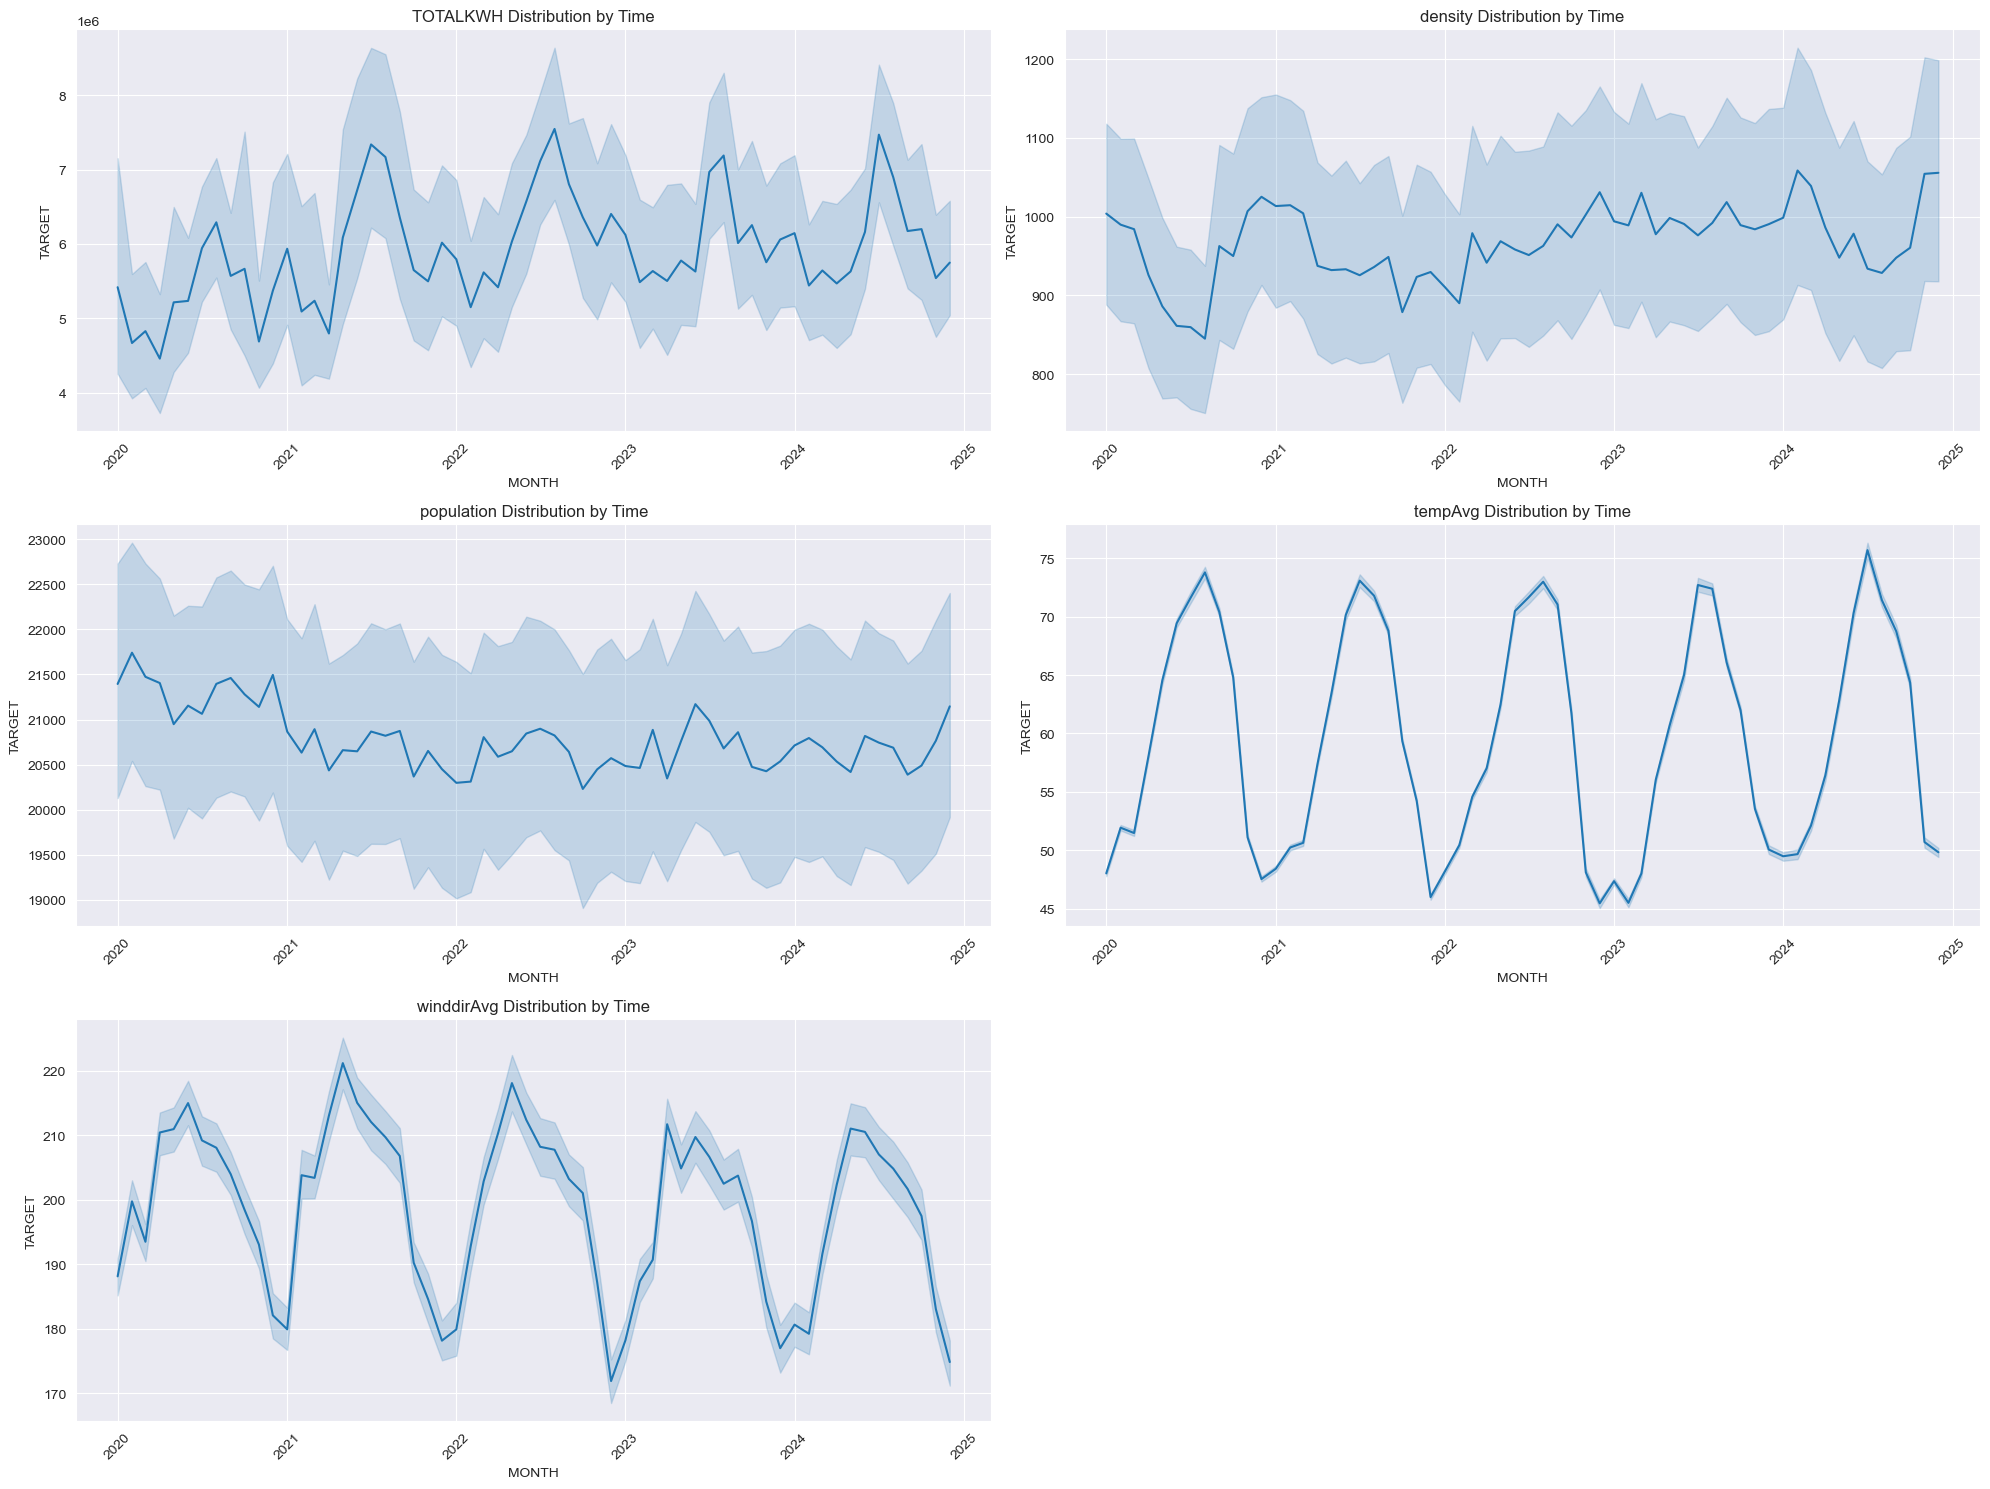

In [282]:
# plot distribution by month

def plot_distri_by_month_main(data, cols, n_cols=2):
    """
    Plot distribution of selected features by YEAR_MONTH.
    
    Input:
    - data: DataFrame, features
    - cols: list, features to plot
    - n_cols: int, number of columns on the same row
    
    Output:
    - None
    
    Sample usage:
    plot_distri_by_month_main(data, cols=['tempAvg', 'winddirAvg'], n_cols=2)
    """
    
    n_rows = (len(cols) + 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten()
    
    for idx, col in enumerate(cols):
        ax = axes[idx]
        sns.lineplot(data=data, x='YEAR_MONTH', y=col, ax=ax)
        ax.set_title(f'{col} Distribution by Time')
        ax.set_xlabel('MONTH')
        ax.set_ylabel('TARGET')
        ax.tick_params(axis='x', rotation=45)
    
    for j in range(len(cols), len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show() 

plot_distri_by_month_main(data_cleaned, time_series_cols, n_cols=2)

# tempAVg and winddirAvg seem to have a seasonal pattern.

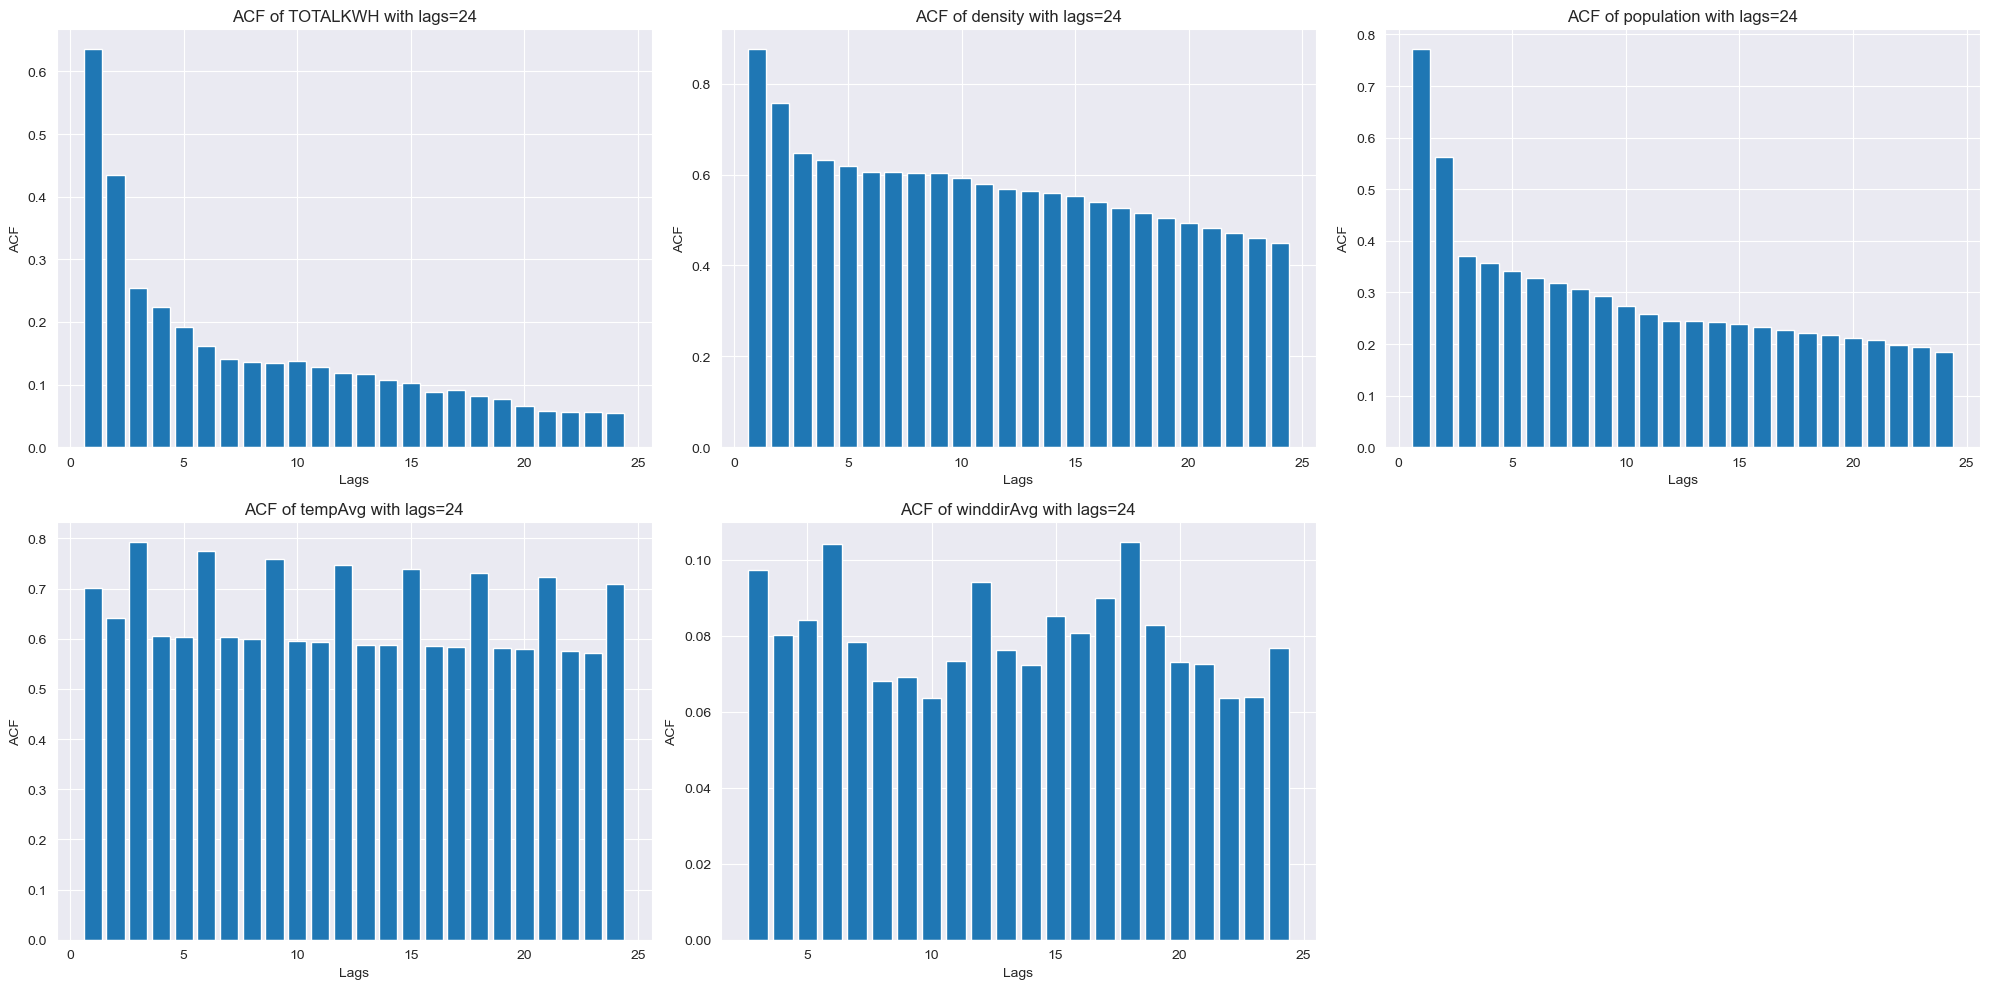

In [295]:
# ACF
from statsmodels.tsa.stattools import acf

def plot_acf_main(data, cols, lags, n_cols=2):
    """
    Plot ACF of selected features.
    
    Input:
    - data: DataFrame, features
    - cols: list, features to plot
    - lags: int, number of lags
    - n_cols: int, number of columns on the same row
    
    Output:
    - None
    
    Sample usage:
    plot_acf_main(data, cols=['tempAvg', 'winddirAvg'], lags=24, n_cols=2)
    """
    n_rows = (len(cols) + 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten()
    
    for idx, col in enumerate(cols):
        ax = axes[idx]
        acf_vals = acf(data[col], nlags=lags)
        if col == 'winddirAvg':
            # skip lag 0-2 due to too high values
            ax.bar(range(3, lags + 1), acf_vals[3:])
        else:
            # skip lag 0 because it is always 1
            ax.bar(range(1, lags + 1), acf_vals[1:])  
        ax.set_title(f'ACF of {col} with lags={lags}')
        ax.set_xlabel('Lags')
        ax.set_ylabel('ACF')
    
    for j in range(len(cols), len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_acf_main(data_cleaned, time_series_cols, lags=24, n_cols=3)
# Only tempAVg appears to have a strong ACF. Though seeming to be time-related, winddirAvg does not have a strong ACF.
# To avoid multi-collinearity, we do not add seasonal features, but keeps tempAVg.

# Write 1-5 together

In [280]:
data = raw.copy()
data[TARGET] = data[TARGET].str.replace(',', '').astype(float)
data = data[data[TARGET] != 0]
data['YEAR_MONTH'] = pd.to_datetime(data['YEAR'].astype(str) + '-' + data['MONTH'].astype(str) + '-01')

data_add_geo = data.merge(geo, left_on='ZIPCODE', right_on='zip', how='left')

num_data = data_add_geo.select_dtypes(include=['float64'])
DROP_COLS = ['zip', 'lat', 'lng', 'parent_zcta', 'county_fips', 'dewptAvg', 'heatindexAvg', 'windchillAvg']
num_data.drop(columns=[col for col in DROP_COLS if col in num_data.columns], inplace=True)

X = num_data.drop(columns=[TARGET])
y = num_data[TARGET]

cor_pearson = cal_corr(X, y, method='pearson', plot=False)
cor_spearman = cal_corr(X, y, method='spearman', plot=False)
threshold = 0.1
for col in X.columns:
    if abs(cor_pearson[col]) < threshold and abs(cor_spearman[col]) < threshold:
        DROP_COLS.append(col)

data_dropped = num_data.drop(columns=[col for col in DROP_COLS if col in num_data.columns])

data_dropped['YEAR_MONTH'] = data_add_geo['YEAR_MONTH']
data_cleaned = data_dropped.dropna()

# 6. Split data into train and test

In [261]:
# sort by YEAR_MONTH
data_cleaned.sort_values(by='YEAR_MONTH', inplace=True)

# Split data into train and test by 8:2, based on time (YEAR_MONTH)
TRAIN_RATIO = 0.8
split_idx = int(len(data_cleaned) * TRAIN_RATIO)
train_data = data_cleaned.iloc[:split_idx]
test_data = data_cleaned.iloc[split_idx:]
print('Train data shape:', train_data.shape)
print('Test data shape:', test_data.shape)

Train data shape: (51322, 6)
Test data shape: (12831, 6)


C:\Users\qingx\AppData\Local\Temp\ipykernel_31600\3684732717.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned.sort_values(by='YEAR_MONTH', inplace=True)


In [262]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51322 entries, 1309 to 50341
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   TOTALKWH    51322 non-null  float64       
 1   tempAvg     51322 non-null  float64       
 2   winddirAvg  51322 non-null  float64       
 3   population  51322 non-null  float64       
 4   density     51322 non-null  float64       
 5   YEAR_MONTH  51322 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(5)
memory usage: 2.7 MB


In [263]:
# save data
train_data.to_feather(TRAIN_DATA_FILE)
test_data.to_feather(TEST_DATA_FILE)